Set up Environment

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Lambda, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K


from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
import zipfile
import cv2

from collections import OrderedDict
from PIL import Image
import hashlib

import random as rn

from glob import glob

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

Python Version:  3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Tensorflow Version:  2.12.0


In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Set up for using GPU

In [ ]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     # Set only the first GPU device to be visible
#     tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
#     print(f"Using only GPU device {physical_devices[0].name}\n")
# else:
#     print("No physical GPU devices found! \n")

# # Verify GPU visibility in TensorFlow
# if tf.config.list_physical_devices('GPU'):
#     print("GPU is available")
# else:
#     print("GPU is not available")



No physical GPU devices found! 

GPU is not available


In [ ]:
# unzip dataset file
# path_to_zip_file = '/content/drive/MyDrive/FlowerCode/Dataset/Flowers.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall('.')
#     zip_ref.close()

# !unzip /content/drive/MyDrive/FlowerCode/Dataset/Flowers.zip -d /content/drive/MyDrive/FlowerCode/Dataset
!unzip /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded.zip -d /content/drive/MyDrive/FlowerCode/Dataset

Archive:  /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded.zip
   creating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/
   creating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Babi/
   creating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_1.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_10.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_100.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_101.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_102.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_103.jpg  
  inflating: /content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded/Calimerio/calimerio_104.jpg  
  inflating: /content/driv

In [31]:
# get name of flower types base on flower type folder names
base_dir = '/content/drive/MyDrive/FlowerCode/Dataset/Flowers/'
sub_folders = [f.name for f in os.scandir(base_dir) if f.is_dir()]
print(sub_folders)

num_classes = len(sub_folders)
print(num_classes)


['Calimerio', 'Lisianthus', 'Hydrangeas', 'Chrysanthemum', 'Tana', 'Pingpong', 'Rosy', 'Babi']
8


In [32]:
image_path=[]
flower=[]
for sub_folder in sub_folders:
    dir_link = base_dir + sub_folder + "/"
    for img_path in os.listdir(dir_link):
        image_path.append(dir_link + img_path)
        flower.append(sub_folder)


In [33]:
Image_path = pd.Series(image_path, name="Image_Path").astype(str)
Image_path.head()

0    /content/drive/MyDrive/FlowerCode/Dataset/Flow...
1    /content/drive/MyDrive/FlowerCode/Dataset/Flow...
2    /content/drive/MyDrive/FlowerCode/Dataset/Flow...
3    /content/drive/MyDrive/FlowerCode/Dataset/Flow...
4    /content/drive/MyDrive/FlowerCode/Dataset/Flow...
Name: Image_Path, dtype: object

In [34]:
Flowers=pd.Series(flower, name="Flower_Types")

data=pd.concat([Image_path, Flowers], axis=1)
data=data.sample(frac=1).reset_index(drop = True)


data.head(5)

,Image_Path,Flower_Types
0,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Lisianthus
1,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Tana
2,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Lisianthus
3,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Chrysanthemum
4,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Chrysanthemum


Exploration Data Analysis (EDA)

<Axes: >

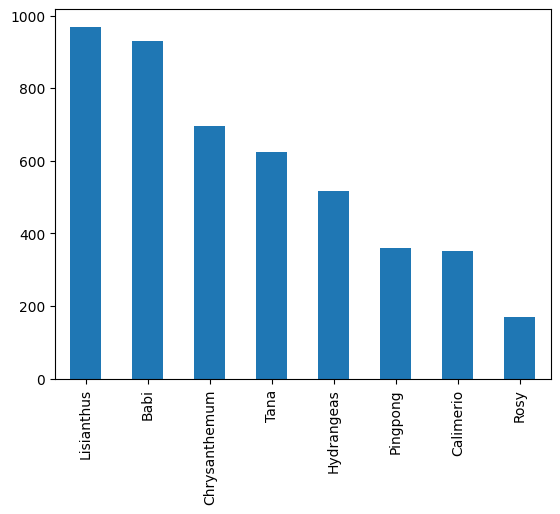

In [11]:
data['Flower_Types'].value_counts().plot.bar()

In [ ]:
print(data['Flower_Types'].value_counts().to_frame())
print("\n")
print(data['Flower_Types'].value_counts(normalize=True).to_frame())

               Flower_Types
Lisianthus              969
Babi                    931
Chrysanthemum           696
Tana                    623
Hydrangeas              518
Pingpong                360
Calimerio               353
Rosy                    171


               Flower_Types
Lisianthus         0.209695
Babi               0.201472
Chrysanthemum      0.150617
Tana               0.134819
Hydrangeas         0.112097
Pingpong           0.077905
Calimerio          0.076390
Rosy               0.037005


In [ ]:
data.shape

(4621, 2)

In [35]:
def get_file_hash(filepath):
    """
    This function returns the SHA-256 hash of a file.
    """
    sha256_hash = hashlib.sha256()
    with open(filepath, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

def find_duplicate_images(directory, other_directory):
    """
    This function finds duplicate images in a directory and another directory.
    Returns a list of lists, where each inner list contains the paths of all duplicate images that are at a distance from each other.
    """
    duplicates = {}
    hashes = set()

    # Traverse the first directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]
            else:
                hashes.add((file_hash, file_size))

    # Traverse the other directory and its subdirectories
    for root, dirs, files in os.walk(other_directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]

    # Group the duplicate images by their hash values and return the list of lists
    groups = []
    for group in duplicates.values():
        if len(group) > 1:
            groups.append(group)
    return groups

['Rosy', 'Hydrangeas', 'Pingpong', 'Chrysanthemum', 'Lisianthus', 'Tana', 'Babi', 'Calimerio']
8


<Axes: >

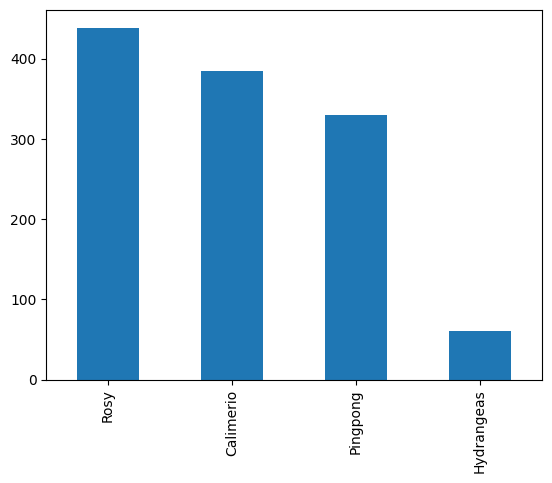

In [36]:
# get additional data of flower types
base_dir_2 = '/content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded'
sub_folders_2 = [f.name for f in os.scandir(base_dir_2) if f.is_dir()]
print(sub_folders_2)

num_classes_2 = len(sub_folders_2)
print(num_classes_2)

image_path_2=[]
flower_2=[]
for sub_folder_2 in sub_folders_2:
    dir_link_2 = base_dir_2 + "/" + sub_folder_2 + "/"
    for img_path_2 in os.listdir(dir_link_2):
        image_path_2.append(dir_link_2 + img_path_2)
        flower_2.append(sub_folder_2)

Image_path_2 = pd.Series(image_path_2, name="Image_Path").astype(str)

Flowers_2=pd.Series(flower_2, name="Flower_Types")
data_added=pd.concat([Image_path_2, Flowers_2], axis=1)


data_added['Flower_Types'].value_counts().plot.bar()


In [37]:
data = data.reset_index(drop=True)
data_added = data_added.reset_index(drop=True)

combined_df = pd.concat([data, data_added], ignore_index=True)

combined_df


,Image_Path,Flower_Types
0,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Lisianthus
1,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Tana
2,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Lisianthus
3,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Chrysanthemum
4,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Chrysanthemum
...,...,...
5830,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Calimerio
5831,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Calimerio
5832,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Calimerio
5833,/content/drive/MyDrive/FlowerCode/Dataset/Flow...,Calimerio


               Flower_Types
Lisianthus              969
Babi                    931
Calimerio               738
Chrysanthemum           696
Pingpong                690
Tana                    623
Rosy                    610
Hydrangeas              578


               Flower_Types
Lisianthus         0.166067
Babi               0.159554
Calimerio          0.126478
Chrysanthemum      0.119280
Pingpong           0.118252
Tana               0.106769
Rosy               0.104542
Hydrangeas         0.099057


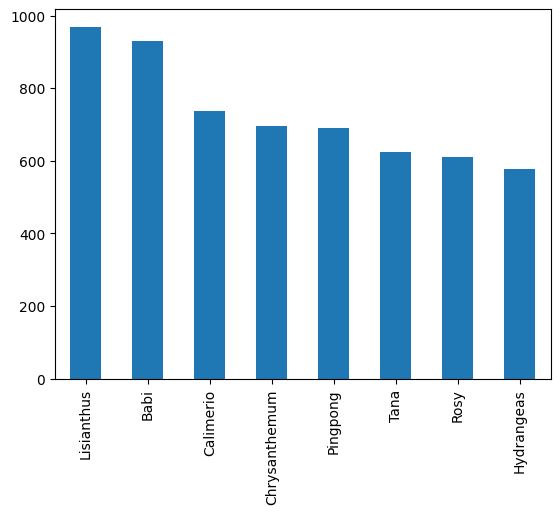

In [38]:
combined_df['Flower_Types'].value_counts().plot.bar()

print(combined_df['Flower_Types'].value_counts().to_frame())
print("\n")
print(combined_df['Flower_Types'].value_counts(normalize=True).to_frame())


In [39]:
directory1 = '/content/drive/MyDrive/FlowerCode/Dataset/Flowers'
directory2 = '/content/drive/MyDrive/FlowerCode/Dataset/FlowersAdded'

duplicates = find_duplicate_images(directory1, directory2)

result = [item for sublist in duplicates[:] for item in sublist[1:]]
print("Amount of duplicated images: " + str(len(result)))

combined_df = combined_df[~combined_df['Image_Path'].isin(result)]

combined_df.reset_index(drop=True, inplace=True)


combined_df.shape

Amount of duplicated images: 34


(5801, 2)

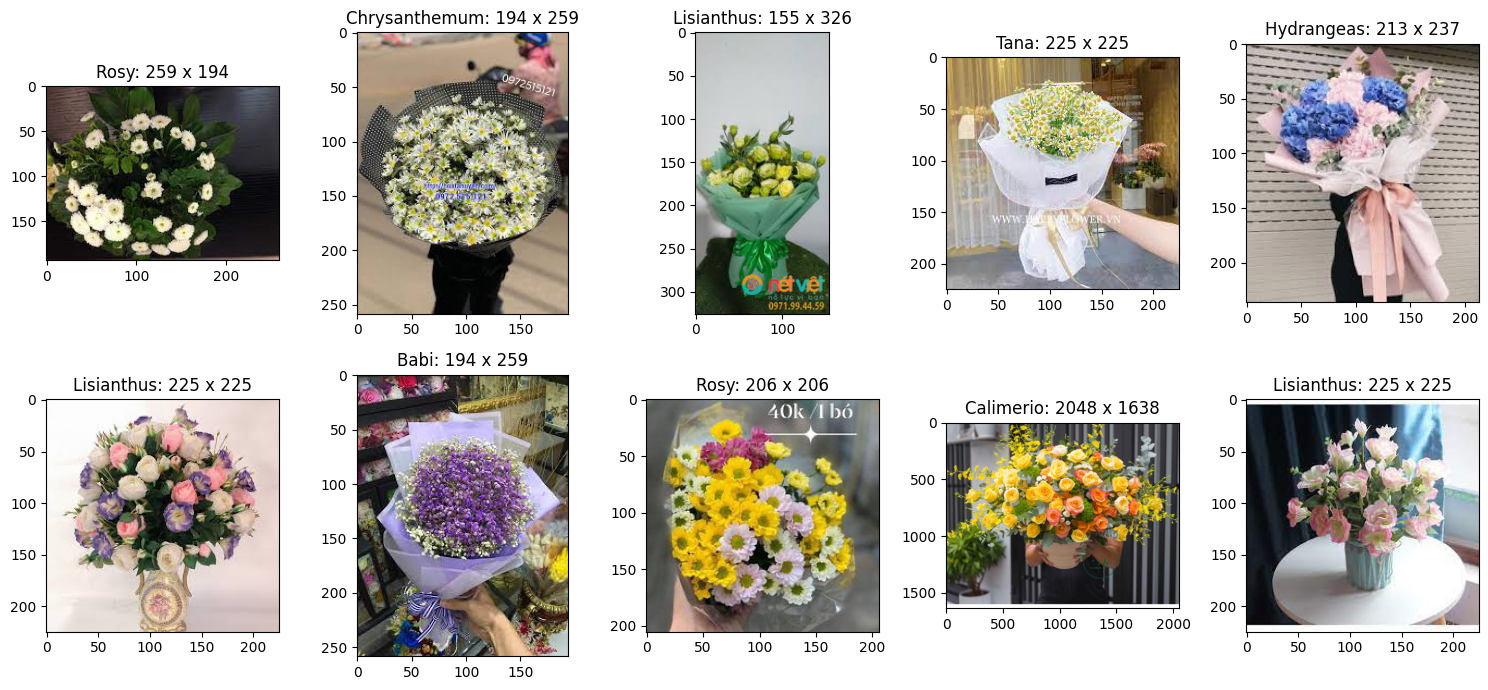

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(combined_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(data.loc[i, "Flower_Types"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

In [40]:
dev, test = train_test_split(combined_df, train_size=0.85, shuffle=True, random_state=333)

In [25]:
dev.shape, test.shape

((4930, 2), (871, 2))

In [41]:
#defined
BATCH_SIZE = 32

IMG_WIDTH  = 224
IMG_HEIGHT = 224

train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=25,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    # width_shift_range=0.2,
                                    # height_shift_range=0.2,
                                    # shear_range=0.2, 
                                    # zoom_range=0.2,
                                    # brightness_range=[0.6, 1.2],
                                    horizontal_flip=True,
                                    # vertical_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)



In [42]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4191 validated image filenames belonging to 8 classes.
Found 739 validated image filenames belonging to 8 classes.
Found 871 validated image filenames.


In [ ]:
# train_ds = train_datagen.flow_from_dataframe(
#     dataframe=train,
#     x_col='Image_Path',
#     y_col='Flower_Types',
#     target_size=(IMG_WIDTH, IMG_HEIGHT),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed=42
# )

# validation_ds = train_datagen.flow_from_dataframe(
#     dataframe=validation,
#     x_col='Image_Path',
#     y_col='Flower_Types',
#     target_size=(IMG_WIDTH, IMG_HEIGHT),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
# )

In [19]:
print(train_ds.class_indices)

{'Babi': 0, 'Calimerio': 1, 'Chrysanthemum': 2, 'Hydrangeas': 3, 'Lisianthus': 4, 'Pingpong': 5, 'Rosy': 6, 'Tana': 7}


(32, 224, 224, 3)
(32, 8)
Label:  [1. 0. 0. 0. 0. 0. 0. 0.]


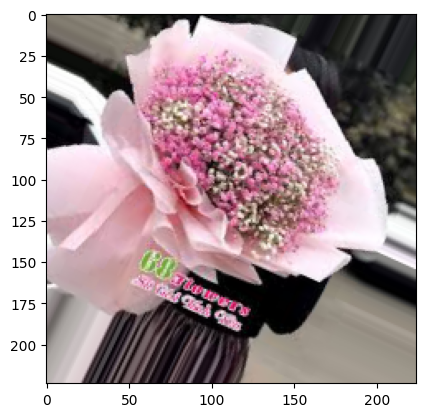

Label:  [0. 0. 0. 0. 0. 0. 0. 1.]


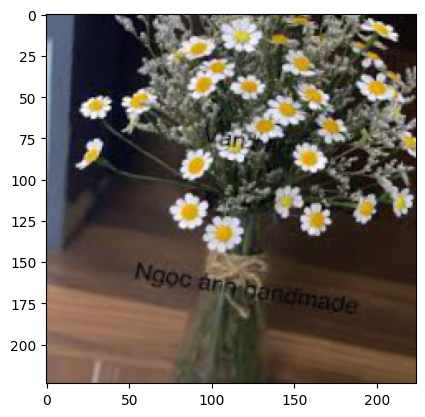

Label:  [0. 0. 0. 0. 0. 1. 0. 0.]


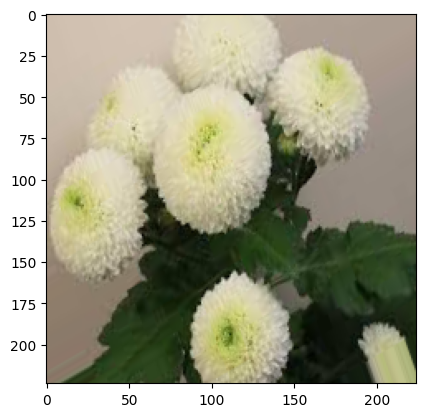

In [28]:
batchX, batchY = train_ds.next()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

In [ ]:
# VGG-12 Model From Scratch

# model = Sequential([
#     # 1st Convolutional Layer
#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     # Dropout(0.2),

#     # 2nd Convolutional Layer
#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     # Dropout(0.3),

#     # 3rd Convolutional Layer
#     Conv2D(filters=256,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=256,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=256,kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     # Dropout(0.3),

#     # 4th Convolutional Layer
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     # Dropout(0.3),

#     # # 5th Convolutional Layer
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=512,kernel_size=(3,3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     # Dropout(0.3),

#     Flatten(),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),

#     Dense(num_classes, activation='softmax')
# ])

# model.summary()

In [ ]:
# Inception_V3 From Scratch

# def inception_v3(input_shape, num_classes):
#     input_tensor = Input(shape=input_shape)

#     # Stem
#     x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu')(input_tensor)
#     x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
#     x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

#     # Inception modules
#     x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])
#     x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
#     x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
#     x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])
#     x = inception_module(x, filters=[160, 112, 224, 24, 64, 64])
#     x = inception_module(x, filters=[128, 128, 256, 24, 64, 64])
#     x = inception_module(x, filters=[112, 144, 288, 32, 64, 64])
#     x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
#     x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
#     x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
#     x = inception_module(x, filters=[384, 192, 384, 48, 128, 128])

#     # Top layers
#     x = AveragePooling2D(pool_size=(8, 8))(x)
#     x = Dropout(0.4)(x)
#     x = Dense(num_classes, activation='softmax')(Flatten()(x))

#     model = keras.models.Model(inputs=input_tensor, outputs=x)

#     return model


# def inception_module(x, filters):
#     """
#     Implementation of an Inception module
#     """
#     filter1, filter2, filter3, filter4, filter5, filter6 = filters

#     branch1 = Conv2D(filter1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)

#     branch2 = Conv2D(filter2, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
#     branch2 = Conv2D(filter3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(branch2)

#     branch3 = Conv2D(filter4, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
#     branch3 = Conv2D(filter5, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(branch3)

#     branch4 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
#     branch4 = Conv2D(filter6, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(branch4)

#     x = concatenate([branch1, branch2, branch3, branch4], axis=3)

#     return x

In [ ]:
# VGG-16 Model From Scratch

# model = Sequential([
#     # Convolutional layers
#     Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     Conv2D(64, kernel_size=3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),
    
#     Conv2D(128, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(128, kernel_size=3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),
    
#     Conv2D(256, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(256, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(256, kernel_size=3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),

#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),

#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     Conv2D(512, kernel_size=3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),

#     # Flatten the output and add fully connected (dense) layers
#     Flatten(),
#     Dense(units=4096, activation='relu'),
#     Dense(units=4096, activation='relu'),
#     Dense(units=num_classes, activation='softmax')
# ])

# model.summary()

In [ ]:
# model = Sequential([
#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

# model.summary()

In [ ]:
# AlexNet 
# model = Sequential([
#     Conv2D(64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),
    
#     Conv2D(192, kernel_size=(5,5), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),


#     Conv2D(384, kernel_size=(3,3), padding='valid', activation='relu'),
#     Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu'),
#     Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu'),

#      MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),

#     Flatten(),
#     Dense(units=4096, activation='relu'),
#     Dropout(0.5),
#     Dense(units=4096, activation='relu'),
#     Dropout(0.5),

#     Dense(num_classes, activation='softmax')
# ])

# model.summary()

In [47]:

# Define the Siamese CNN model architecture
def create_siamese_cnn(input_shape):
    # Define the input layers
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    # Define the shared convolutional layers
    conv_layer1 = Conv2D(32, (3,3), activation='relu')
    conv_layer2 = Conv2D(64, (3,3), activation='relu')
    pool_layer = MaxPooling2D((2,2))

    # Define the first branch of the Siamese CNN model
    x1 = conv_layer1(input1)
    x1 = pool_layer(x1)
    x1 = conv_layer2(x1)
    x1 = pool_layer(x1)
    x1 = Flatten()(x1)

    # Define the second branch of the Siamese CNN model
    x2 = conv_layer1(input2)
    x2 = pool_layer(x2)
    x2 = conv_layer2(x2)
    x2 = pool_layer(x2)
    x2 = Flatten()(x2)

    # Concatenate the output of the two branches
    concatenated = Concatenate()([x1, x2])

    # Define the fully connected layers
    fc_layer1 = Dense(512, activation='relu')
    fc_layer2 = Dense(128, activation='relu')
    output_layer = Dense(num_classes, activation='softmax')

    # Connect the fully connected layers to the concatenated output
    x = fc_layer1(concatenated)
    x = fc_layer2(x)
    output = output_layer(x)

    # Define the Siamese CNN model
    model = keras.Model(inputs=[input1, input2], outputs=output)

    return model

model = create_siamese_cnn(input_shape=(224, 224, 3))
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 222, 222, 32  896         ['input_11[0][0]',               
                                )                                 'input_12[0][0]']               
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  multiple            0           ['conv2d_12[0][0]',              
                                                                  'conv2d_13[0][0]',        

In [48]:
optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)


history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


ValueError: ignored

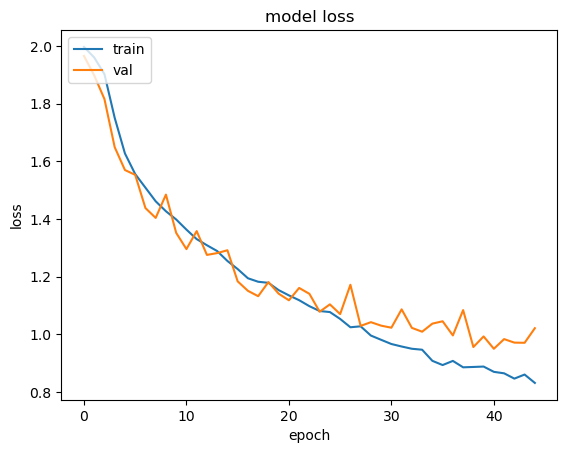

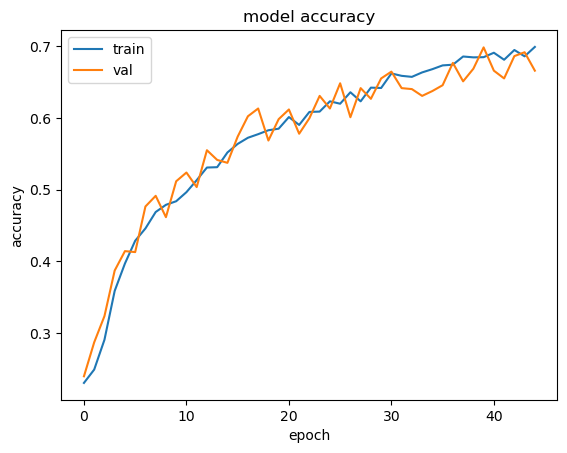

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
batchXTest, batchYTest = val_ds.next()

score = model.evaluate(batchXTest, batchYTest)

1/1 [==============================] - 0s 48ms/step - loss: 0.7817 - accuracy: 0.7812


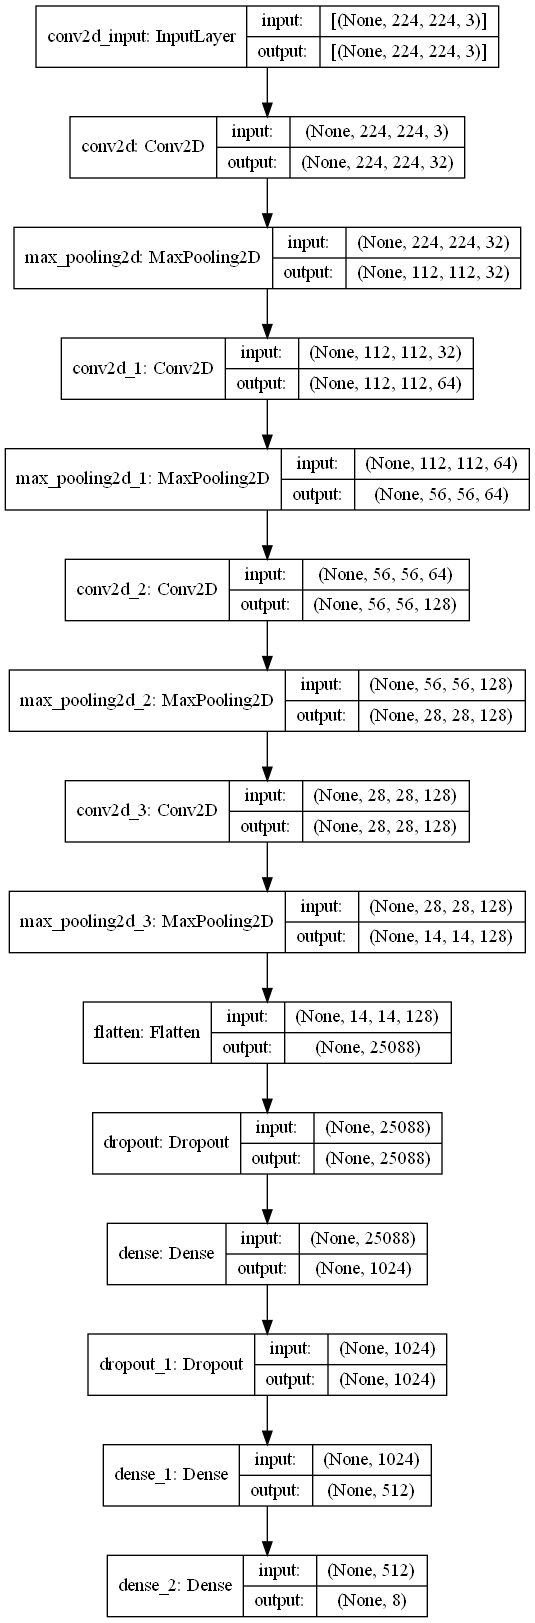

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
model.save('./TrainingModels/flower_classification_model.h5')